## Medical image data - BoneMRI


In [1]:
# Library imports
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import os
import napari

from image_utils import *

dicom_path = os.path.join("boneMRI", "20240119_BoneMRI_EBS24")
segmentation_path = os.path.join("boneMRI", "20240119_BoneMRI_EBS24_Segmentation.nii")

## Loading the data

The shape of the image is (100, 672, 672)


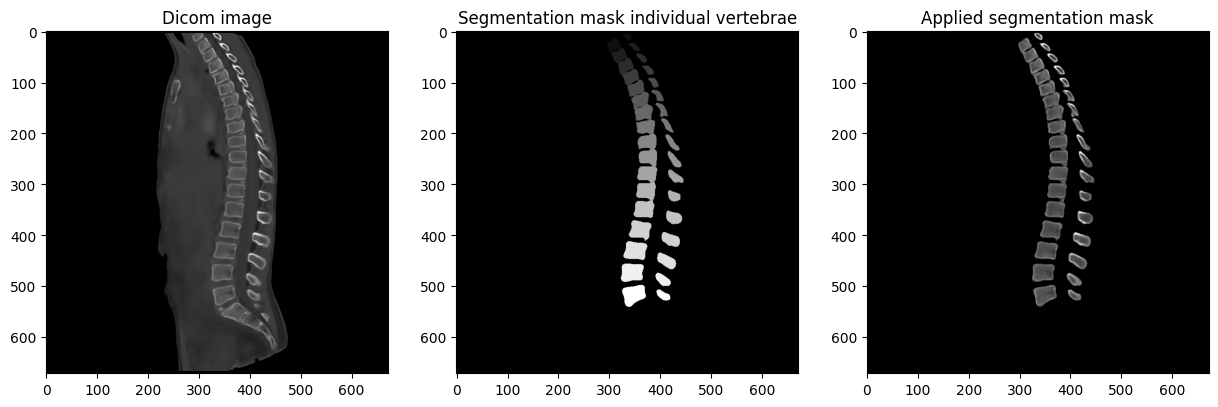

In [2]:
# Load segmentation data
segment = sitk.ReadImage(segmentation_path)
segment_data = sitk.GetArrayFromImage(segment)
segment_all = segment_data > 0

# Load dicom data and apply windowing
dicom_image = load_3d_dicom(dicom_path)
dicom_image = apply_window(dicom_image, window_level=450, window_width=1500)
segment_dicom_image = dicom_image*segment_all
print(f"The shape of the image is {dicom_image.shape}")

# Plot data 
slice_index = 50  # Middle slice along the z-axis
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(dicom_image[slice_index, ...], cmap='gray')
ax[0].set_title("Dicom image")
ax[1].imshow(segment_data[slice_index, ...], cmap='gray')
ax[1].set_title("Segmentation mask individual vertebrae")
ax[2].imshow(segment_dicom_image[slice_index, ...], cmap='gray')
ax[2].set_title("Applied segmentation mask");

## Generate radiographs/compressions from 3D CT data

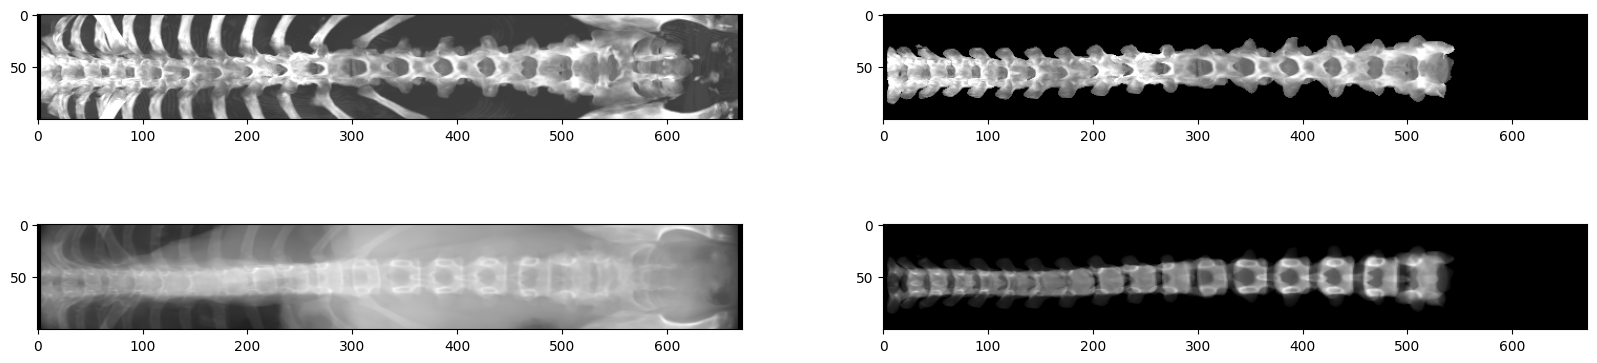

In [3]:
# Create a radiograph from CT
radiograph = get_radiograph(dicom_image, axis=0)
segment_radiograph = get_radiograph(segment_dicom_image, axis=0)
compressed = compress_bonemri(dicom_image, axis=2)
segment_compressed = compress_bonemri(segment_dicom_image, axis=2)

fig, ax = plt.subplots(2, 2, figsize=(20, 5))
ax = ax.flatten()
ax[0].imshow(radiograph, cmap="gray")
ax[1].imshow(segment_radiograph, cmap="gray")
ax[2].imshow(compressed, cmap="gray")
ax[3].imshow(segment_compressed, cmap="gray");

## Image rotation

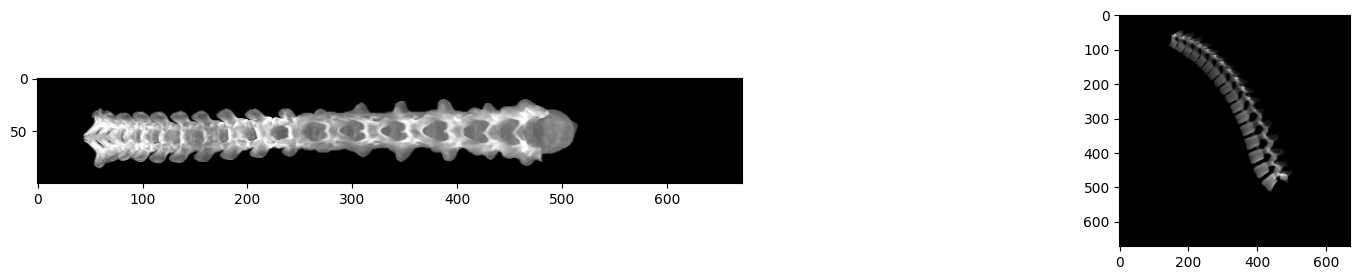

In [4]:
# Apply rotation and compressions
rotated_spine = rotate_3D(segment_dicom_image, sagittal_angle=30)
rotated_radiograph = get_radiograph(rotated_spine, axis=0)
rotated_compressed = compress_bonemri(rotated_spine, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax[0].imshow(rotated_radiograph, cmap="gray")
ax[1].imshow(rotated_compressed, cmap="gray");

## Bounding cubes - Individual vertebrae

In [5]:
# Obtain unique labels for the vertebrae (skipping zero)
vertebrae_labels = np.unique(segment_data)[1:]

# Find bounding cube coordinates for each vertebrae
bounding_box_coords = {}
bounding_box_masks = {}
for label in vertebrae_labels:
    # Get bounding box
    vertebra_mask = (segment_data == label)
    bbox_coord, bbox_mask = compute_bbox(vertebra_mask)

    # Store bounding box data
    bounding_box_coords[int(label)] = bbox_coord
    bounding_box_masks[int(label)] = bbox_mask

# viewer = napari.Viewer()
# viewer.add_image(segment_dicom_image, name="Segmented CT")
# for label, bcube in bounding_cubes_mask.items():
#     viewer.add_labels(bcube, name=f"Bounding cube {label}")
# viewer.dims.ndisplay = 3
# napari.run()

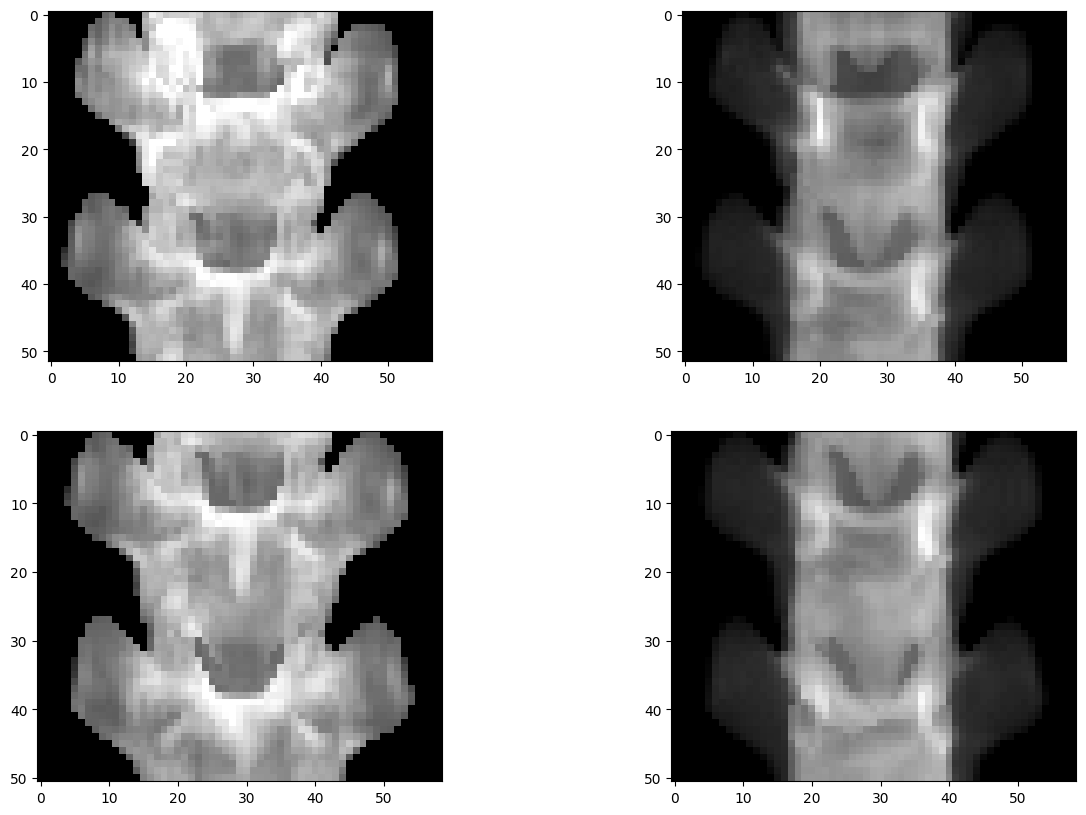

In [6]:
# Plot for individual vertebrae bounding cubes
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for idx, label in enumerate(vertebrae_labels[4:6]):
    # Obtain individual segmented vertebra bbox image
    bcube_coord = bounding_box_coords[label]
    bcube_vertebra = segment_dicom_image[
        bcube_coord["z_min"]-5:bcube_coord["z_max"]+5,
        bcube_coord["y_min"]:bcube_coord["y_max"],
        bcube_coord["x_min"]:bcube_coord["x_max"],
    ]
    # Plot radiograph
    bcube_radiograph = get_radiograph(bcube_vertebra, axis=0)
    ax[idx,0].imshow(np.rot90(bcube_radiograph, 3), cmap="gray")
    # Plot compressed image
    bcube_compressed = compress_bonemri(bcube_vertebra, axis=2)
    ax[idx,1].imshow(np.rot90(bcube_compressed, 3), cmap="gray")

## Principle component analysis - Individual vertebrae

In [7]:
# Store results for each vertebra
centered_points = {}
principal_components = {}
euler_angles = {}

for label in vertebrae_labels:
    # Create a binary mask for the specific vertebra
    vertebra_mask = (segment_data == label)

    # Compute the oriented bounding box (OBB)
    points, pc, angles = compute_pca(vertebra_mask, int(label))

    # Store results
    centered_points[int(label)] = points
    principal_components[int(label)] = pc
    euler_angles[int(label)] = angles

print(f"Computed bounding box for {len(vertebrae_labels)} vertebra")

Computed bounding box for 17 vertebra


In [13]:
# Obtain target vertebra
label = 15
vertebra_mask = (segment_data == label).astype(int)
vertebra_points = centered_points[label]
# vertebra_points = vertebra_points[vertebra_points[:, 1] < np.percentile(vertebra_points[:, 1], 95)]
pc = principal_components[label]

# Display vertebra cloud of points
viewer = napari.Viewer()
viewer.add_points(vertebra_points, size=1, face_color='white', name='Vertebra Points')

# Add principle components (eigenvectors)
axis_colors = ['red', 'green', 'blue']
scale = np.linalg.norm(vertebra_points.max(axis=0) - vertebra_points.min(axis=0)) * 0.2
for i in range(len(pc)):
    # Origin and scaled direction for PCs
    start = vertebra_points.mean(axis=0)
    end = vertebra_points.mean(axis=0) + pc[i] * scale
    # Add as lines in Napari
    viewer.add_shapes(
        np.array([[start, end]]), 
        shape_type='line',
        edge_color=axis_colors[i], 
        edge_width=1, 
        name=f'PC{i+1} ({axis_colors[i]})'
    )

viewer.dims.ndisplay = 3
napari.run()

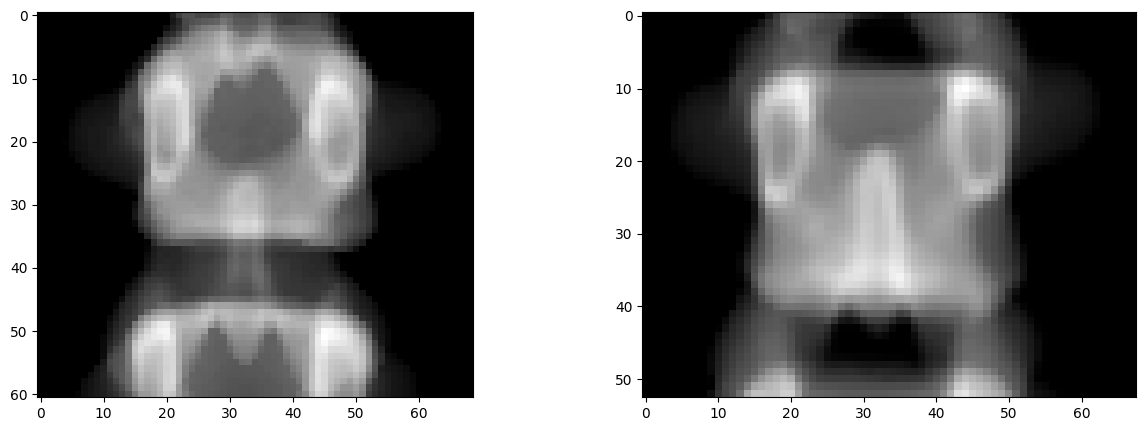

In [14]:
# Obtain individual segmented vertebra bbox image
bbox_coord = bounding_box_coords[label]
bbox_vertebra_image = segment_dicom_image[
    bbox_coord["z_min"]-5:bbox_coord["z_max"]+5,
    bbox_coord["y_min"]:bbox_coord["y_max"],
    bbox_coord["x_min"]:bbox_coord["x_max"],
]

# Use angles to rotate the dicom image and segmentation mask
rot_segment_dicom_image = rotate_3D(segment_dicom_image,
    sagittal_angle=euler_angles[label][0],
    axial_angle=euler_angles[label][2]
)
rot_vertebra_mask = rotate_3D(vertebra_mask,
    sagittal_angle=euler_angles[label][0],
    axial_angle=euler_angles[label][2]
)

# Obtain individual segmented and rotated vertebra bbox image
rot_bbox_coord, rot_bbox_mask = compute_bbox(rot_vertebra_mask)
rot_bbox_vertebra_image = rot_segment_dicom_image[
    rot_bbox_coord["z_min"]-5:rot_bbox_coord["z_max"]+5,
    rot_bbox_coord["y_min"]:rot_bbox_coord["y_max"],
    rot_bbox_coord["x_min"]:rot_bbox_coord["x_max"],
]

# Plot for individual compressedvertebrae bounding cubes
bbox_vertebra_compressed = compress_bonemri(bbox_vertebra_image, axis=2)
rot_bbox_vertebra_compressed = compress_bonemri(rot_bbox_vertebra_image, axis=2)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(np.rot90(bbox_vertebra_compressed, 3), cmap="gray")
ax[1].imshow(np.rot90(rot_bbox_vertebra_compressed, 3), cmap="gray");

In [15]:
print(euler_angles[label])

[12.28463196  4.28694921 -0.80438242]
